In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
print(pd.__version__)
print(tf.__version__)

1.1.4
2.5.0


In [2]:
# Get Food101 data
download_data = False
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             download=download_data,
                                             with_info=True)

In [3]:
# Dataset features
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [4]:
# Class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [5]:
# Take one sample of train data
train_one_sample = train_data.take(1)
train_one_sample # Samples are in the format (image_tensor, label)

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [6]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image type: {image.dtype}
  Image class: {label}
  Class name: {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image type: <dtype: 'uint8'>
  Image class: 16
  Class name: cheesecake
  


In [7]:
tf.reduce_min(image), tf.reduce_max(image) # Image has values in [0, 255]

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

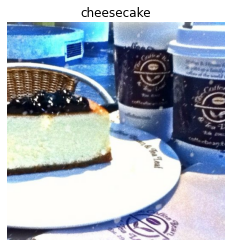

In [8]:
# Plot an image
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [9]:
# Create preprocessing function
def preprocess_img(image, label, img_size=224, rescale=False):
  """
  Convert image from 'uint8' -> 'float32' and reshapes it to
  [img_shape, img_shape, 3]
  If rescale=True the image is rescaled to [0, 1]
  """
  image = tf.image.resize(image, [img_size, img_size])
  if rescale:
    image /= 255.
  return tf.cast(image, tf.float32), label

In [10]:
# Apply preprocess_img to all images
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train data, turn it into batches, and prefetch it
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Same steps for test set (but no need to shuffle)
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [12]:
# Create model (feature extraction)
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

input_shape = (224, 224, 3)

# Create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # Freeze layers of base model

# Define model via functional API
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False) # Do NOT train this!
x = layers.GlobalAveragePooling2D(name="pooling2D")(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              # NOTE: 0.001 is default value for learning rate
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling2D (GlobalAveragePool (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [14]:
# Check that base model is frozen
for layer in model.layers:
  print(f"{layer.name}: trainable? {layer.trainable}")

input_layer: trainable? True
efficientnetb0: trainable? False
pooling2D: trainable? True
dense: trainable? True


In [ ]:
# Fit feature extraction model
train_model = False
if train_model:
    # NOTE: on Colab with a Tesla T4, training for 3 epochs takes ~10 minutes (with checkpoints)
    history_1 = model.fit(train_data,
                          epochs=3,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=int(0.15 * len(test_data)))
else:
    model = tf.keras.models.load_model("feature_extraction_model")
    history_1 = pd.read_csv("training/history1.csv")

In [ ]:
# Evaluate on full test set (70.37% accuracy)
model.evaluate(test_data)